In [1]:
!pip install -q insightface opencv-python-headless

In [2]:
!pip install -q onnxruntime-gpu insightface

In [14]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from insightface.app import FaceAnalysis
import matplotlib.pyplot as plt
import zipfile

In [12]:
def extract_cropped_faces(video_folder, output_base_folder, fps_sampling=1, target_size=(299, 299), max_faces_per_frame=1,max_videos=None):
    os.makedirs(output_base_folder, exist_ok=True)
    
    # Initialize the RetinaFace model
    face_app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    face_app.prepare(ctx_id=0, det_size=(512, 512))  # ctx_id=0 uses GPU

    
    video_files = [f for f in os.listdir(video_folder) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
    if max_videos:
        video_files = video_files[:max_videos]

    for i, video_file in enumerate(video_files):
        video_path = os.path.join(video_folder, video_file)
        video_id = os.path.splitext(video_file)[0]
        output_folder = os.path.join(output_base_folder, video_id)
        os.makedirs(output_folder, exist_ok=True)

        print(f"[{i+1}/{len(video_files)}] Processing {video_file}...")

        cap = cv2.VideoCapture(video_path)
        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_interval = int(fps / fps_sampling) if fps_sampling != 0 else 1

        count, saved = 0, 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            if count % frame_interval == 0:
                # Detect faces
                faces = face_app.get(frame)
    
                for i, face in enumerate(faces[:max_faces_per_frame]):
                    bbox = face.bbox.astype(int)
                    x1, y1, x2, y2 = bbox
    
                    # Crop and resize
                    cropped_face = frame[y1:y2, x1:x2]
                    if cropped_face.size == 0:
                        continue
                    resized_face = cv2.resize(cropped_face, target_size)
                    # Save the face crop
                    save_path = os.path.join(output_folder, f"{video_id}_frame{saved:04d}.jpg")
                    cv2.imwrite(save_path, resized_face)
                    saved += 1
                    
            count += 1
            
        cap.release()
        print(f"    → Saved {saved} face crops to {output_folder}")

def zip_output_folder(folder_path, zip_path):
    """
    Compress output folder into a zip file.
    """
    with zipfile.ZipFile(zip_path, 'w') as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                filepath = os.path.join(root, file)
                arcname = os.path.relpath(filepath, folder_path)
                zipf.write(filepath, arcname)

def plot_sample_faces(output_base_folder, samples=5):
    all_folders = [os.path.join(output_base_folder, f) for f in os.listdir(output_base_folder) 
                  if os.path.isdir(os.path.join(output_base_folder, f))]
    all_folders=all_folders[:samples]
    for folder in all_folders:
        image_files = sorted([f for f in os.listdir(folder) if f.endswith('.jpg')])
        if not image_files:
            continue
        print(f"Samples from {os.path.basename(folder)}:")
        plt.figure(figsize=(15, 3))
        samples_per_video = len(image_files)
        for i, img_file in enumerate(image_files):
            img_path = os.path.join(folder, img_file)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(1, samples_per_video, i+1)
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title(img_file)
        plt.tight_layout()
        plt.show()

In [7]:
# Usage
video_path_real = '/kaggle/input/celeb-df-v2/Celeb-real'
video_path_fake = '/kaggle/input/celeb-df-v2/Celeb-synthesis'
output_folder = '/kaggle/working/cropped_frames'
output_folder_real = '/kaggle/working/cropped_frames/real'
output_folder_fake = '/kaggle/working/cropped_frames/fake'
zip_path = 'kaggle/working/cropped_frames.zip'
    
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_folder_real, exist_ok=True)
os.makedirs(output_folder_fake, exist_ok=True)

extract_cropped_faces(video_path_real, output_folder_real,fps_sampling=1, target_size=(299, 299), max_faces_per_frame=1)
extract_cropped_faces(video_path_fake, output_folder_fake,fps_sampling=1, target_size=(299, 299), max_faces_per_frame=1)
plot_sample_faces(output_folder_real, samples=5)
plot_sample_faces(output_folder_fake, samples=5)
zip_output_folder(output_folder,zip_path)

Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}, 'CUDAExecutionProvider': {'sdpa_kernel': '0', 'use_tf32': '1', 'fuse_conv_bias': '0', 'prefer_nhwc': '0', 'tunable_op_max_tuning_duration_ms': '0', 'enable_skip_layer_norm_strict_mode': '0', 'tunable_op_tuning_enable': '0', 'tunable_op_enable': '0', 'use_ep_level_unified_stream': '0', 'device_id': '0', 'has_user_compute_stream': '0', 'gpu_external_empty_cache': '0', 'cudnn_conv_algo_search': 'EXHAUSTIVE', 'cudnn_conv1d_pad_to_nc1d': '0', 'gpu_mem_limit': '18446744073709551615', 'gpu_external_alloc': '0', 'gpu_external_free': '0', 'arena_extend_strategy': 'kNextPowerOfTwo', 'do_copy_in_default_stream': '1', 'enable_cuda_graph': '0', 'user_compute_stream': '0', 'cudnn_conv_use_max_workspace': '1'}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CUDAExecutionProvider', 'CPUExecutionProvider'], with o

/usr/local/lib/python3.11/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


    → Saved 11 face crops to /kaggle/working/cropped_frames/real/id49_0006
[2/590] Processing id27_0008.mp4...
    → Saved 12 face crops to /kaggle/working/cropped_frames/real/id27_0008
[3/590] Processing id32_0000.mp4...
    → Saved 18 face crops to /kaggle/working/cropped_frames/real/id32_0000
[4/590] Processing id1_0006.mp4...
    → Saved 17 face crops to /kaggle/working/cropped_frames/real/id1_0006
[5/590] Processing id50_0006.mp4...
    → Saved 15 face crops to /kaggle/working/cropped_frames/real/id50_0006
[6/590] Processing id55_0006.mp4...
    → Saved 9 face crops to /kaggle/working/cropped_frames/real/id55_0006
[7/590] Processing id0_0005.mp4...
    → Saved 16 face crops to /kaggle/working/cropped_frames/real/id0_0005
[8/590] Processing id32_0008.mp4...
    → Saved 16 face crops to /kaggle/working/cropped_frames/real/id32_0008
[9/590] Processing id0_0008.mp4...
    → Saved 16 face crops to /kaggle/working/cropped_frames/real/id0_0008
[10/590] Processing id3_0008.mp4...
    → Sa

NameError: name 'plt' is not defined

Samples from id38_0007:


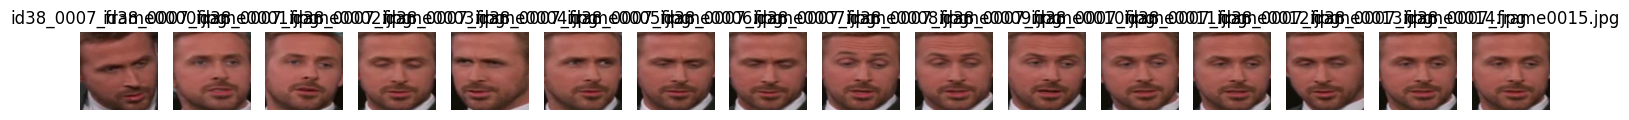

Samples from id4_0006:


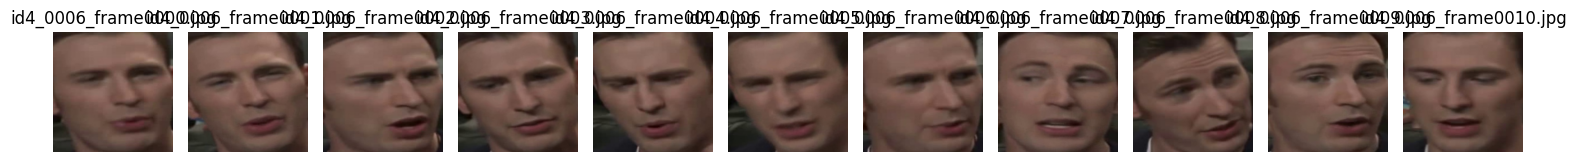

Samples from id49_0001:


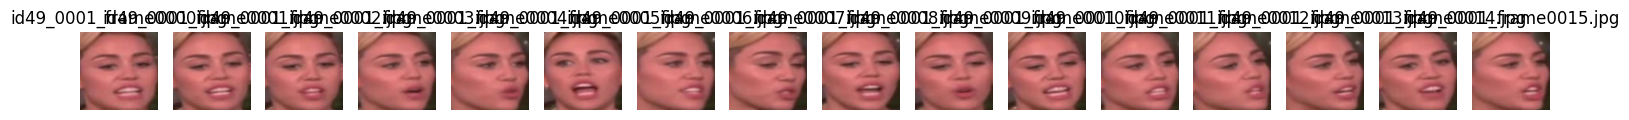

Samples from id49_0006:


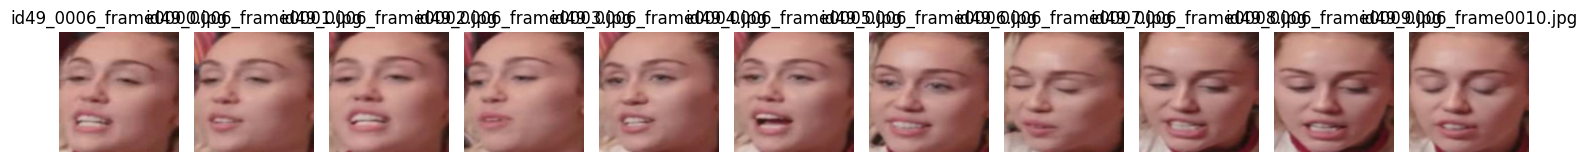

Samples from id1_0009:


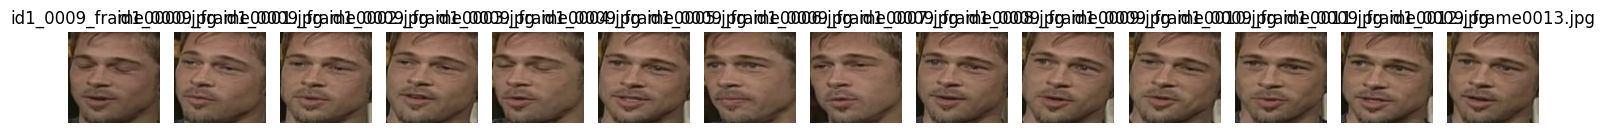

Samples from id20_id35_0009:


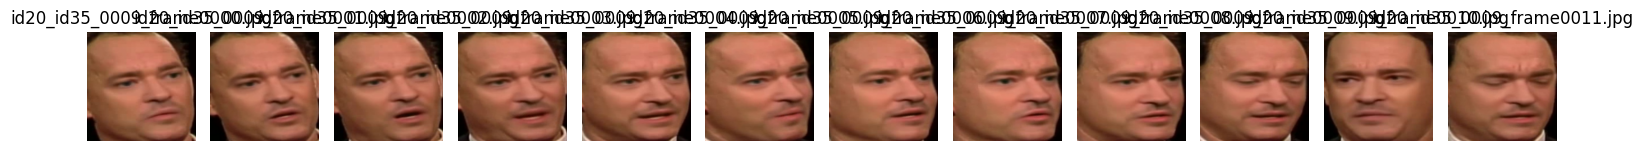

Samples from id26_id0_0006:


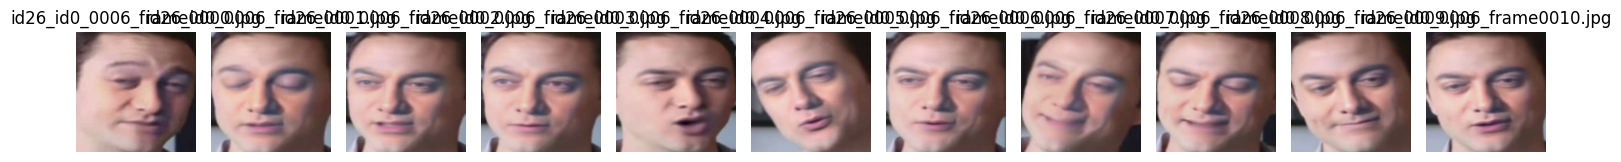

Samples from id27_id20_0004:


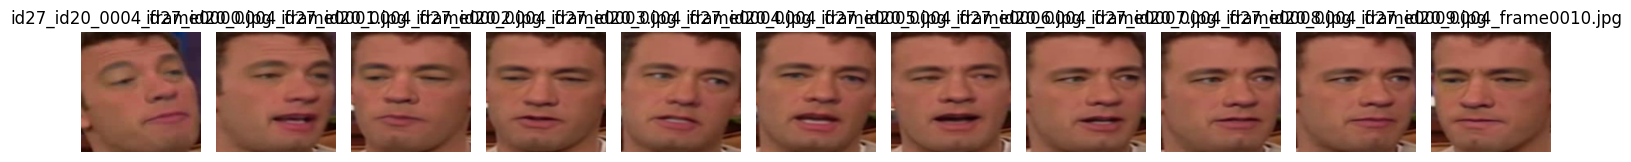

Samples from id2_id28_0001:


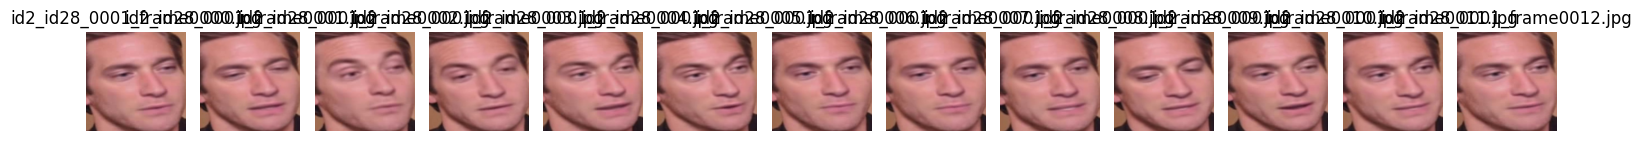

Samples from id34_id31_0009:


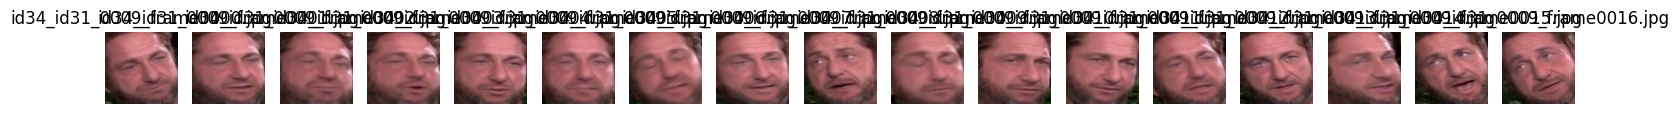

NameError: name 'zipfile' is not defined

In [13]:
plot_sample_faces(output_folder_real, samples=5)
plot_sample_faces(output_folder_fake, samples=5)

In [16]:
zip_path = '/kaggle/working/cropped_frames.zip'
zip_output_folder(output_folder,zip_path)